In [34]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
from Tools.plotting import CandlePlot
import pandas_ta as ta
from Technicals.indicators import TRIX

In [35]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../DB/5m/INJUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [36]:
params = {
    "trix_length": 35,
    "trix_signal_length": 7,
    "trix_signal_type": "sma",
    "long_ma_length": 50,
    "long_ma_type": "sma",
}

In [37]:
class Strategy():
    def __init__(
        self,
        df,
        type=['long', 'short'],
        params=params,
    ):
        self.df = df.copy()
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        df = self.df
        params = self.params
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )

        df = TRIX(df, n=20)
        self.df = df[100:]

        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        params = self.params
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        
        if self.use_long:
            # Open long market signal
            df.loc[
                (df["TRIX"].shift(1) > df["TRIX_SIGNAL"].shift(1)) & 
                (df["TRIX"] < df["TRIX_SIGNAL"]),
                "open_long_market"
            ] = True

            # Close long market signal
            df.loc[
                (df["TRIX"].shift(1) < df["TRIX_SIGNAL"].shift(1)) & 
                (df["TRIX"] > df["TRIX_SIGNAL"]),  # Opposite of open-long condition
                "close_long_market"
            ] = True

        if self.use_short:
            # Open short market signal
            df.loc[
                (df["TRIX"].shift(1) < df["TRIX_SIGNAL"].shift(1)) & 
                (df["TRIX"] > df["TRIX_SIGNAL"]),
                "open_short_market"
            ] = True

            # Close short market signal
            df.loc[
                (df["TRIX"].shift(1) > df["TRIX_SIGNAL"].shift(1)) & 
                (df["TRIX"] < df["TRIX_SIGNAL"]),  # Opposite of open-short condition
                "close_short_market"
            ] = True
            self.df = df   
            return self.df
    
    def run_backtest(self, initial_wallet=1000, start_date=None, end_date=None):
        if start_date:
            self.df = self.df.loc[start_date:]
        if end_date:
            self.df = self.df.loc[:end_date]

        df = self.df
        params = self.params
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG --
                    
                        if row["close_long_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            close_price - current_position["price"]
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "LONG",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )

                        open_price = row['close']
                        fee = wallet * taker_fee
                        wallet -= fee
                        pos_size = wallet
                        current_position = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "SHORT",
                        }

                elif current_position['side'] == "SHORT":                     
                    # -- Close SHORT --
                    
                        if row["close_short_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            current_position["price"] - close_price
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "SHORT",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )

                        open_price = row['close']
                        fee = wallet * taker_fee
                        wallet -= fee
                        pos_size = wallet
                        current_position = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "LONG",
                        }

            # -- Check for opening position --
         
                
                
               
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
            "params": self.params
        }
    
    def plot(self, win):
        
        dfplt = self.df[win:win+1000]
        cp = CandlePlot(dfplt)
            # Find the date range in dfplt
        start_date = dfplt.index.min()  # assuming dfplt index is datetime
        end_date = dfplt.index.max()
        
        # Filter trades within the date range of dfplt
        trades_in_range = self.trades[
            ((self.trades['open_date'] >= start_date) & (self.trades['open_date'] <= end_date)) |
            ((self.trades['close_date'] >= start_date) & (self.trades['close_date'] <= end_date))
        ]
        cp.add_traces(['TRIX', 'TRIX_SIGNAL'])
        cp.add_entries(trades_in_range)
        cp.show_plot()

In [38]:
strat = Strategy(df_t, params=params)

In [39]:
strat.populate_indicators()

,open,high,low,close,volume,TRIX,TRIX_SIGNAL
datetime,,,,,,,
2022-11-21 11:35:00,1.569,1.586,1.568,1.580,0,-0.016473,-0.026089
2022-11-21 11:40:00,1.580,1.581,1.579,1.579,0,-0.014550,-0.024977
2022-11-21 11:45:00,1.579,1.580,1.577,1.578,0,-0.012504,-0.023776
2022-11-21 11:50:00,1.578,1.582,1.577,1.581,0,-0.010241,-0.022474
2022-11-21 11:55:00,1.581,1.581,1.576,1.576,0,-0.008143,-0.021096
...,...,...,...,...,...,...,...
2024-09-04 04:05:00,15.645,15.651,15.603,15.608,0,-0.024563,-0.058394
2024-09-04 04:10:00,15.608,15.630,15.600,15.627,0,-0.021417,-0.054873
2024-09-04 04:15:00,15.627,15.631,15.572,15.576,0,-0.018805,-0.051438


In [42]:
df_m = strat.populate_buy_sell()
df_m[df_m['open_short_market'] == True]

,open,high,low,close,volume,TRIX,TRIX_SIGNAL,open_long_market,close_long_market,open_short_market,close_short_market
datetime,,,,,,,,,,,
2022-11-21 20:20:00,1.559,1.561,1.556,1.556,0,-0.063121,-0.064624,False,True,True,False
2022-11-22 00:10:00,1.583,1.586,1.582,1.585,0,0.022279,0.021569,False,True,True,False
2022-11-22 05:35:00,1.504,1.509,1.503,1.509,0,-0.058890,-0.059644,False,True,True,False
2022-11-22 08:45:00,1.471,1.476,1.471,1.476,0,-0.069816,-0.070388,False,True,True,False
2022-11-22 15:55:00,1.569,1.570,1.562,1.564,0,0.076106,0.075651,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-03 02:00:00,17.254,17.372,17.245,17.316,0,0.009405,0.009070,False,True,True,False
2024-09-03 07:40:00,17.064,17.104,17.056,17.092,0,-0.022837,-0.023256,False,True,True,False
2024-09-03 10:35:00,16.745,16.751,16.703,16.704,0,-0.046743,-0.047297,False,True,True,False


In [41]:

# strat.generate_signals()

# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])


!!! No trades


TypeError: 'NoneType' object is not subscriptable

In [69]:
strat.plot(-3000)

In [65]:
strat.df.tail(100)

,open,high,low,close,volume,TRIX,TRIX_SIGNAL,open_long_market,close_long_market,open_short_market,close_short_market
datetime,,,,,,,,,,,
2024-09-03 20:10:00,16.283,16.298,16.245,16.289,0,-0.011329,-0.017544,False,False,False,False
2024-09-03 20:15:00,16.289,16.313,16.251,16.276,0,-0.010210,-0.016846,False,False,False,False
2024-09-03 20:20:00,16.276,16.330,16.263,16.298,0,-0.008871,-0.016086,False,False,False,False
2024-09-03 20:25:00,16.298,16.298,16.244,16.258,0,-0.007607,-0.015279,False,False,False,False
2024-09-03 20:30:00,16.258,16.338,16.258,16.295,0,-0.006228,-0.014417,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-04 04:05:00,15.645,15.651,15.603,15.608,0,-0.024563,-0.058394,False,False,False,False
2024-09-04 04:10:00,15.608,15.630,15.600,15.627,0,-0.021417,-0.054873,False,False,False,False
2024-09-04 04:15:00,15.627,15.631,15.572,15.576,0,-0.018805,-0.051438,False,False,False,False


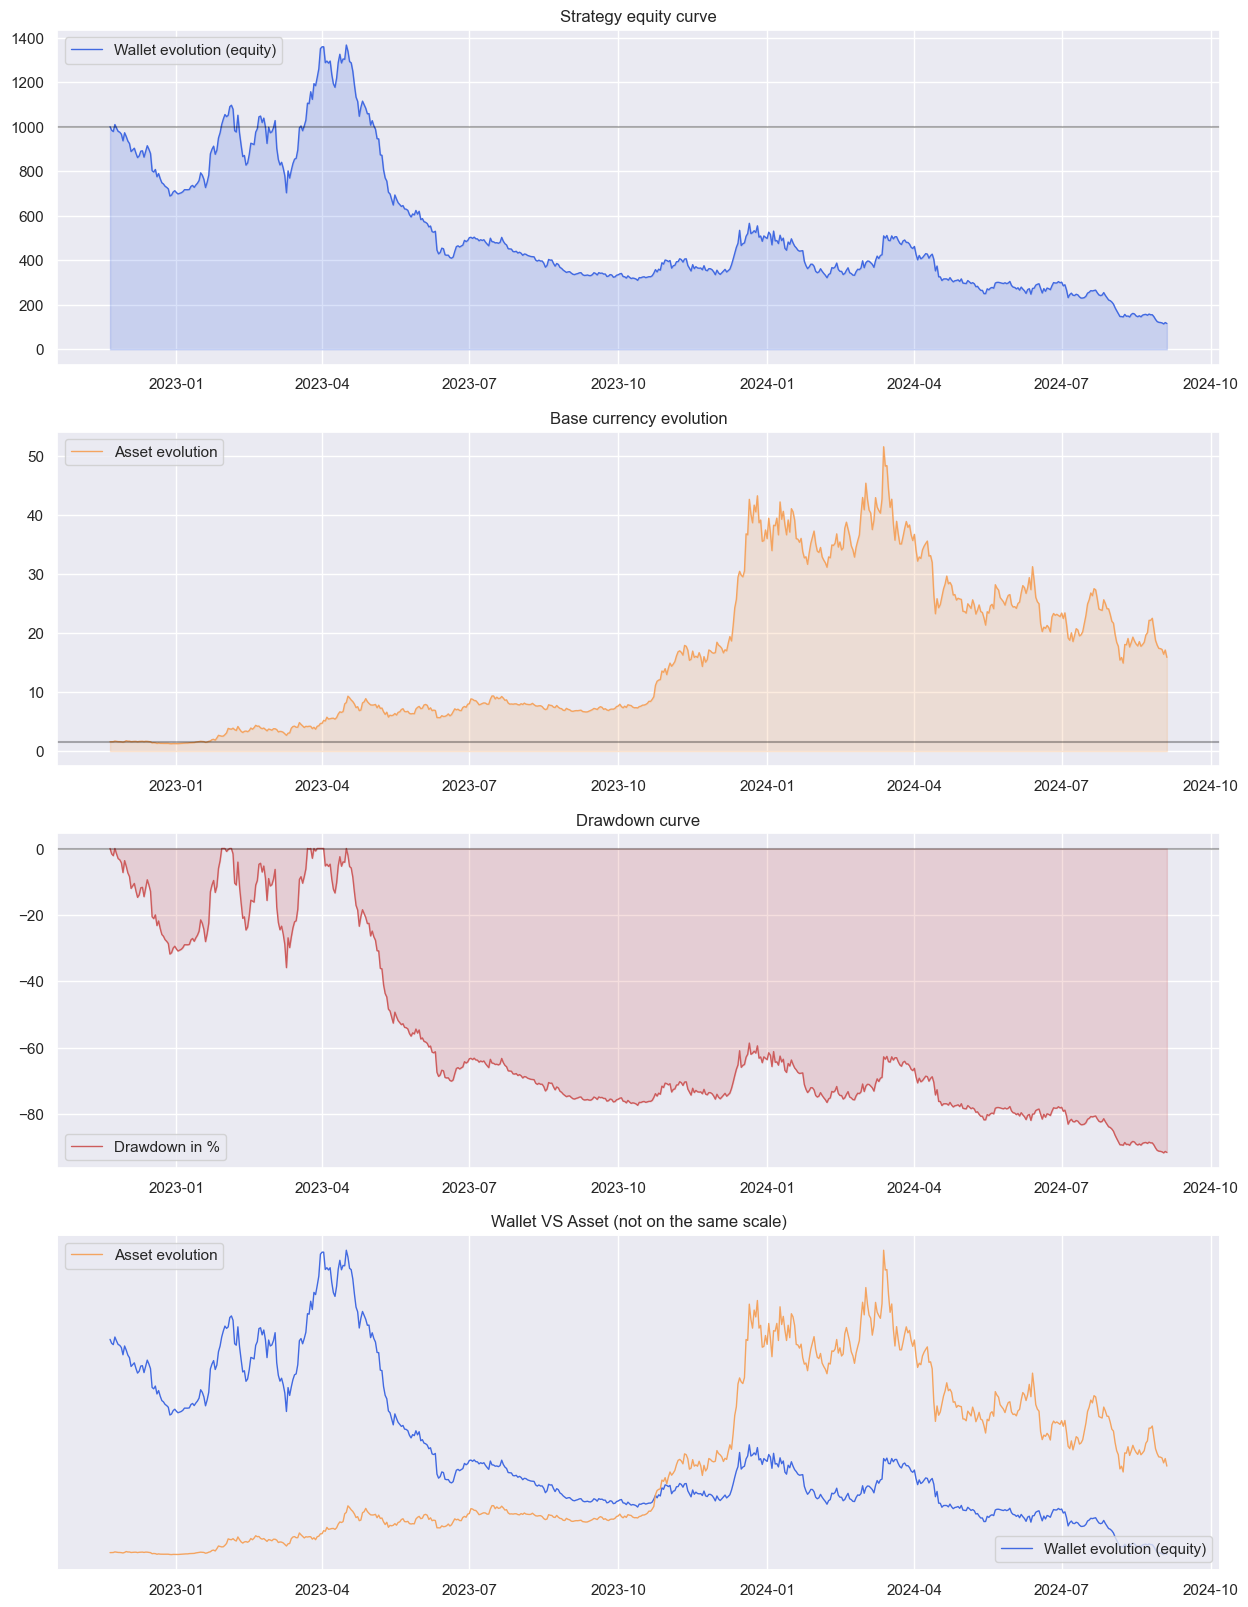

In [66]:
plot_wallet_vs_asset(df_days=df_days)

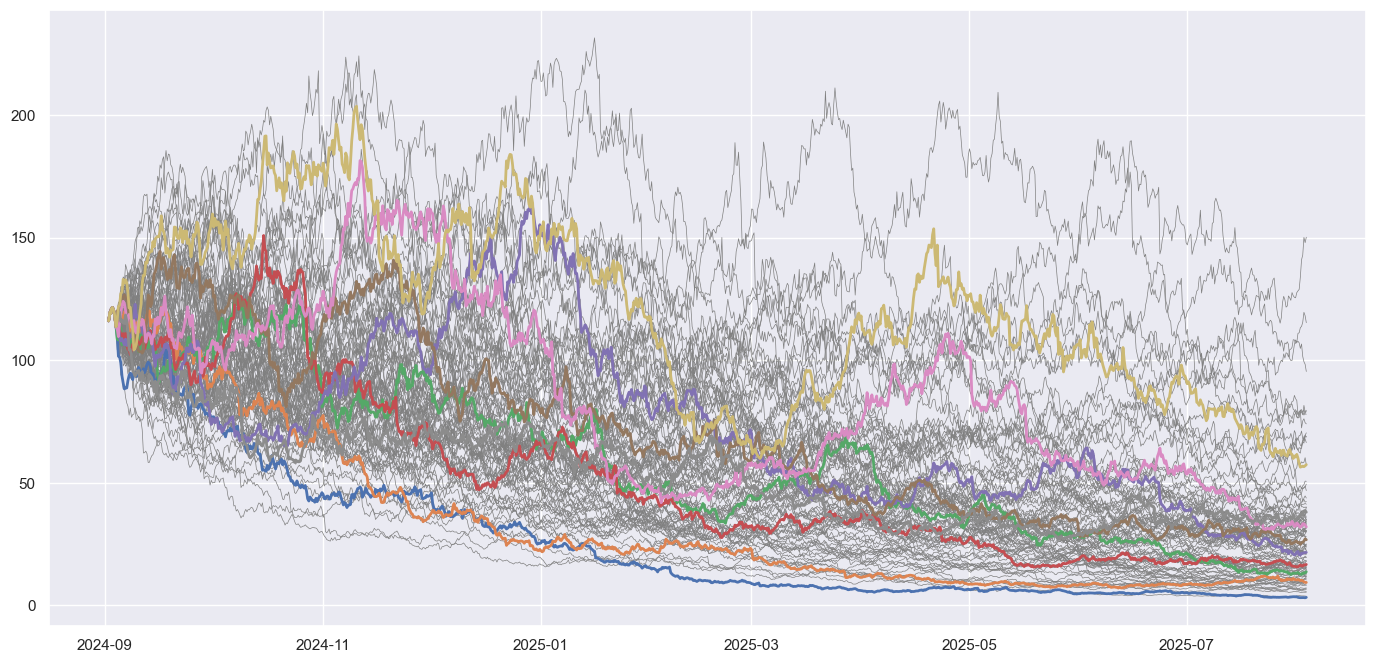

In [ ]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=1,
    trades_to_forecast=1000,
    number_of_simulations=100,
    true_trades_to_show=10,
    show_all_simulations=True,
)

----- 2022 Cumulative Performances: -28.74% -----


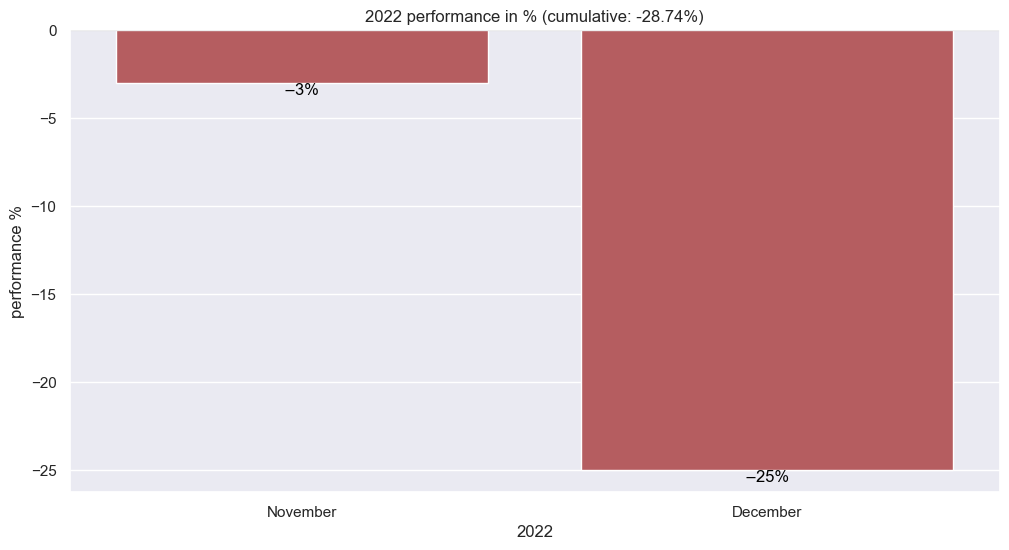

----- 2023 Cumulative Performances: -28.57% -----


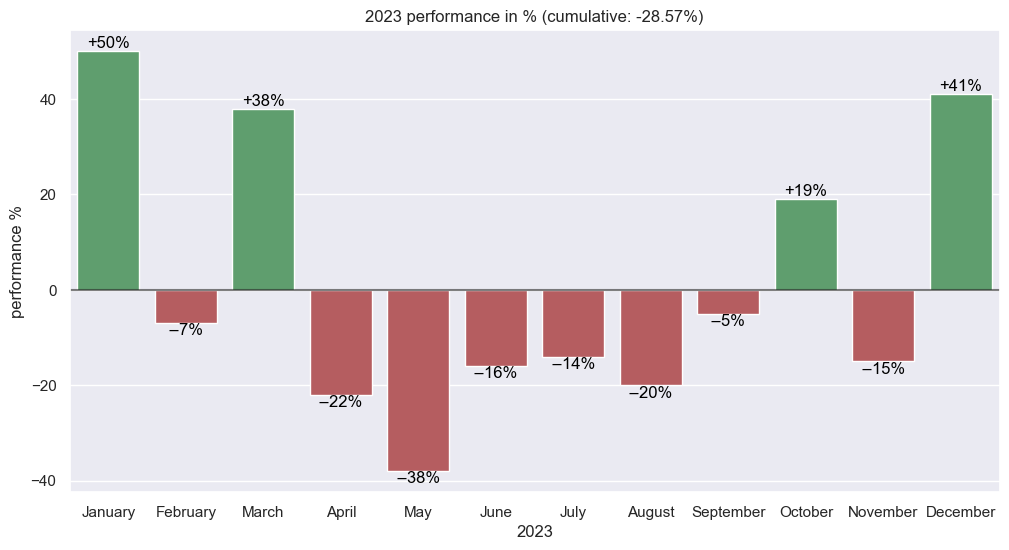

----- 2024 Cumulative Performances: -76.65% -----


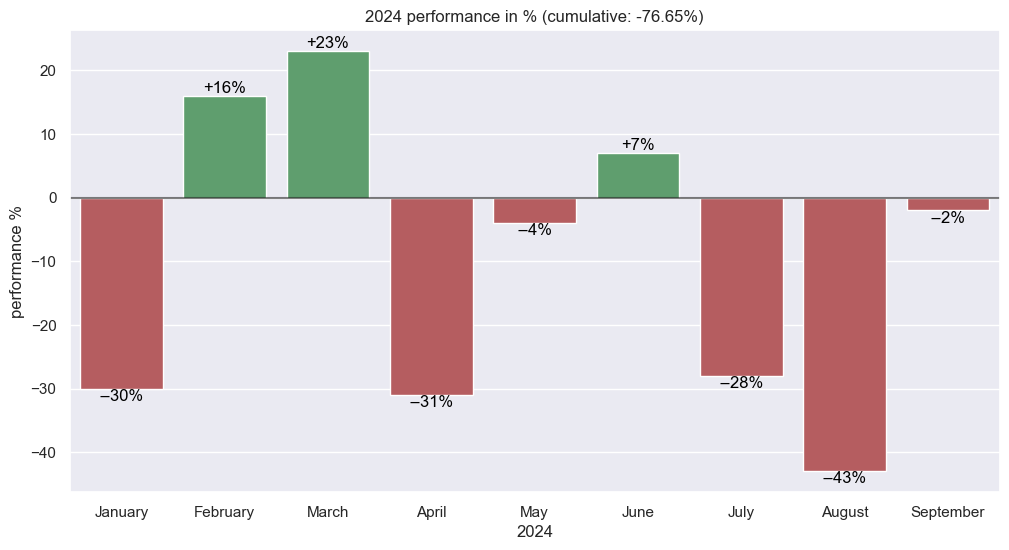

In [ ]:
plot_bar_by_month(df_days=df_days)